## **1. Data Preparation** 
#### Importing Libraries

In [1]:
import os
import gzip
import urllib.request
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,precision_score,recall_score


import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
import time
import copy

### **1.1 Data Loading**

In [2]:
urls = {
    "train_images": "https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz",
    "test_images": "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels": "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz"
}

NOTE: Official URL dataset extract fails - http://yann.lecun.com/exdb/mnist/

In [3]:
# Function to download and extract files
def download_and_extract(url, path, is_label=False):
    if not os.path.exists(path):
        print(f"Downloading {url}...")
        urllib.request.urlretrieve(url, path)
        print(f"Downloaded {path}")
    else:
        print(f"{path} already exists, skipping download.")

    offset = 8 if is_label else 16 # Handle labels separately as their header is 8 bytes instead of 16
    with gzip.open(path, 'rb') as f:
        return np.frombuffer(f.read(), np.uint8, offset=offset)

In [4]:
def load_mnist_data():
    os.makedirs('./data', exist_ok=True)

    train_images = download_and_extract(urls['train_images'], './data/train-images.gz')
    train_labels = download_and_extract(urls['train_labels'], './data/train-labels.gz', is_label=True)
    test_images = download_and_extract(urls['test_images'], './data/test-images.gz')
    test_labels = download_and_extract(urls['test_labels'], './data/test-labels.gz', is_label=True)

    # Reshape and normalize the images
    train_images = train_images.reshape(-1, 28, 28) / 255.0
    test_images = test_images.reshape(-1, 28, 28) / 255.0

    # Combine train and test datasets for custom split
    images = np.concatenate((train_images, test_images), axis=0)
    labels = np.concatenate((train_labels, test_labels), axis=0)

    return images, labels

images, labels = load_mnist_data()
print("MNIST data downloaded and loaded.")

./data/train-images.gz already exists, skipping download.
./data/train-labels.gz already exists, skipping download.
./data/test-images.gz already exists, skipping download.
./data/test-labels.gz already exists, skipping download.
MNIST data downloaded and loaded.


### **1.2 Data Preprocessing**

In [5]:
def split_data(images, labels):
    total_size = len(images)

    # Sizes for each split
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size

    train_images, train_labels = images[:train_size], labels[:train_size]
    val_images, val_labels = images[train_size:train_size+val_size], labels[train_size:train_size+val_size]
    test_images, test_labels = images[train_size+val_size:], labels[train_size+val_size:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

# Split into training, validation, and testing sets (60%, 20%, 20%)
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = split_data(images, labels)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 42000
Validation set size: 14000
Test set size: 14000


In [6]:
len(train_labels)

42000

In [7]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        # Convert numpy arrays to torch tensors
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.long).clone().detach()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def get_images(self):
        return self.images

In [8]:
# Create dataset objects
train_dataset = MNISTDataset(train_images, train_labels)
val_dataset = MNISTDataset(val_images, val_labels)
test_dataset = MNISTDataset(test_images, test_labels)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_iter = iter(train_loader)
images, labels = next(train_iter)
print(f"Batch image shape: {images.shape}, Batch label shape: {labels.shape}")

Batch image shape: torch.Size([64, 1, 28, 28]), Batch label shape: torch.Size([64])


In [9]:
print(f"Number of rows in train_dataset: {len(train_dataset)}")
print(f"Number of rows in test_dataset: {len(test_dataset)}")
print(f"Number of rows in val_dataset: {len(val_dataset)}")

Number of rows in train_dataset: 42000
Number of rows in test_dataset: 14000
Number of rows in val_dataset: 14000


### **1.3 Data Analysis and Visualization**

#### 1.3.1 Sample Images - Visualization

In [10]:
# plot samples with labels
def plot_samples(images, labels, class_names, num_samples=6):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')  # Reshape to 28x28
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')

class_names = [str(i) for i in range(10)]
N = 1000  # Num of images for correlation

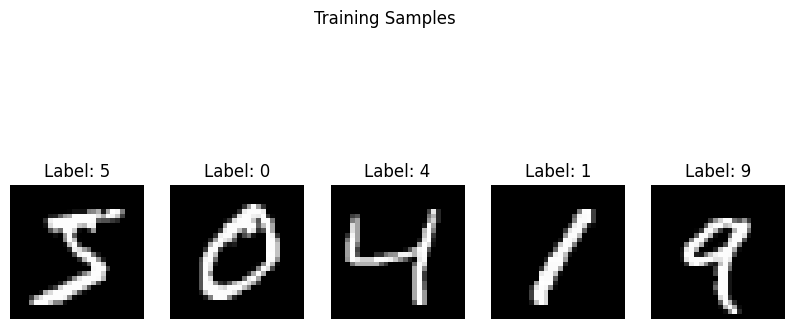

In [11]:
# Convert the first N images to a numpy array (assuming N is defined)
train_images = train_dataset.get_images().numpy()[:N]

train_labels = torch.tensor([train_dataset[i][1] for i in range(N)]).numpy()

# Plot the first N samples
plot_samples(train_images[:5], train_labels[:5], class_names, num_samples=5)
plt.suptitle('Training Samples')
plt.show()

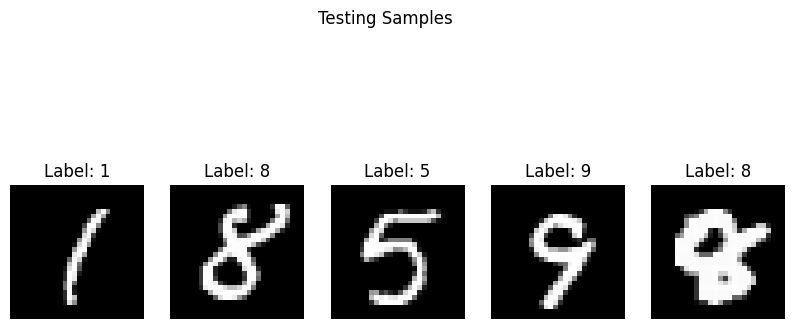

In [12]:
# Plot testing samples
test_images = torch.stack([test_dataset[i][0] for i in range(5)])
test_labels = torch.tensor([test_dataset[i][1] for i in range(5)])
plot_samples(test_images.numpy(), test_labels.numpy(), class_names, num_samples=5)
plt.suptitle('Testing Samples')
plt.show()

#### 1.3.2 Mean and Standard Deviation

<function matplotlib.pyplot.axis(arg: 'tuple[float, float, float, float] | bool | str | None' = None, /, *, emit: 'bool' = True, **kwargs) -> 'tuple[float, float, float, float]'>

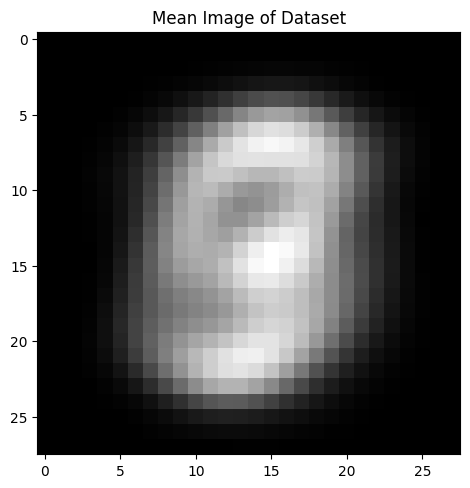

In [13]:
# Calculate mean and standard deviation across the dataset
mean_image = torch.mean(train_dataset.get_images().float(), dim=0)  # Mean of dataset
std_image = torch.std(train_dataset.get_images().float(), dim=0)    # Standard deviation of dataset

# Plot the mean and standard deviation images
plt.figure(figsize=(12, 6))

# Mean image
plt.subplot(1, 2, 1)
plt.imshow(mean_image.squeeze(), cmap='gray')  # .squeeze() to remove channel dimension for plotting
plt.title("Mean Image of Dataset")
plt.axis


#### 1.3.3 Correlation Matrix of MNIST pixel values

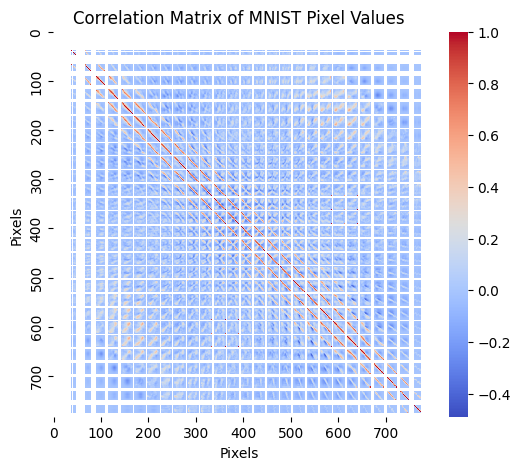

In [14]:
import warnings

train_images = torch.stack([train_dataset[i][0] for i in range(N)])
train_labels = torch.tensor([train_dataset[i][1] for i in range(N)])
train_images = train_images.view(N, -1).numpy()

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(train_images.T)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True, xticklabels=100, yticklabels=100)
plt.title('Correlation Matrix of MNIST Pixel Values')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

#### 1.3.4 Distribution of Digits

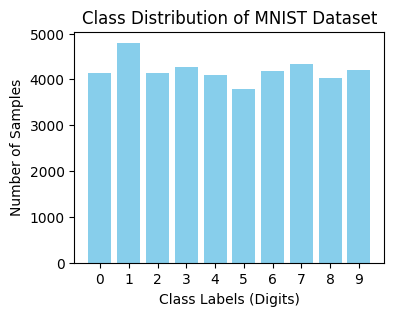

In [15]:
labels = train_dataset.labels

unique, counts = np.unique(labels.numpy(), return_counts=True)

# Create a bar plot for class distribution
plt.figure(figsize=(4, 3))
plt.bar(unique, counts, color='skyblue')
plt.title('Class Distribution of MNIST Dataset')
plt.xlabel('Class Labels (Digits)')
plt.ylabel('Number of Samples')
plt.xticks(unique)  # Set x-axis ticks to be the class labels
plt.show()

In [16]:
print(f"Total Training Samples: {len(train_dataset)}")
print(f"Total Testing Samples: {len(test_dataset)}")
print(f"Total Validation Samples: {len(val_dataset)}")
print(f"Image Shape: {train_dataset[0][0].shape}")
print(f"Number of Classes: {len(unique)}")

Total Training Samples: 42000
Total Testing Samples: 14000
Total Validation Samples: 14000
Image Shape: torch.Size([1, 28, 28])
Number of Classes: 10


#### 1.3.5 Principal Component Analysis (PCA) on dataset

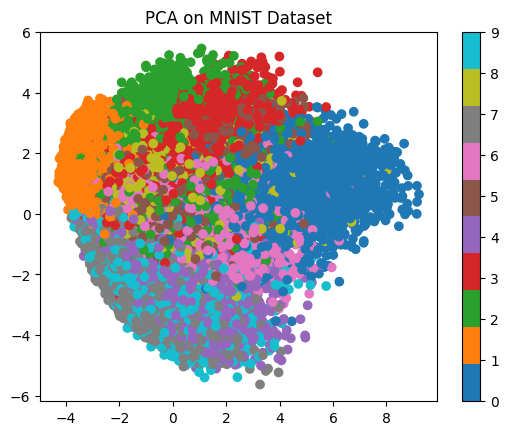

In [17]:
# Flatten the images for PCA
data = train_dataset.get_images().view(-1, 28*28).numpy()
labels = train_dataset.labels.numpy()

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('PCA on MNIST Dataset')
plt.show()

### 1.4 **Data Augmentation**

#### 1.4.1 Rotating selected images in the dataset to increase the diversity in data

**Procedure**

Define the transformations to rotate the images to left and right by 15 and 5 degrees.
A function is defined to rotate and replace since the same code can be reused for training and testing.
The dataset, no of classes and the portion of data in which we are going to select are used as inputs to the function.
Inside the function, create a dictionary to store the indices of data points belonging to each class.
format of the dictionary will be like {0 :[],1:[]}.
since we are going to rotate to left by 15 and 5 and rotate tight to by 15 and 5 divide the dataset to 4 to avoid any duplicates





In [18]:
# Set random seed for reproducibility
random.seed(42)

# Define transformations for rotations
rotate_r15 = transforms.RandomRotation(degrees=(-15, -15))
rotate_r5 = transforms.RandomRotation(degrees=(-5, -5))
rotate_l15 = transforms.RandomRotation(degrees=(5, 5))
rotate_l5 = transforms.RandomRotation(degrees=(15, 15))

# Function to divide, rotate, and replace a portion of images from each class
def rotate_and_replace(dataset, selected_portion):
    # Retrieve data without reshaping
    data = dataset.get_images().numpy()

    # Initialize class_indices dynamically
    class_indices = {}
    for img_index in range(len(dataset)):
        _, label = dataset[img_index]
        label = int(label.item() if isinstance(label, torch.Tensor) else label)

        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(img_index)

    # Apply rotations
    for indices in class_indices.values():
        num_to_rotate = int(len(indices) * selected_portion)
        selected_indices = random.sample(indices, num_to_rotate)
        quarter_size = num_to_rotate // 4

        for idx in selected_indices[:quarter_size]:
            data[idx] = (rotate_r15(dataset[idx][0]) * 255).byte().numpy()

        for idx in selected_indices[quarter_size:2 * quarter_size]:
            data[idx] = (rotate_r5(dataset[idx][0]) * 255).byte().numpy()

        for idx in selected_indices[2 * quarter_size:3 * quarter_size]:
            data[idx] = (rotate_l15(dataset[idx][0]) * 255).byte().numpy()

        for idx in selected_indices[3 * quarter_size:]:
            data[idx] = (rotate_l5(dataset[idx][0]) * 255).byte().numpy()

    # Update dataset with transformed data
    dataset.data = torch.from_numpy(data)
    return dataset

Apply for the training set

In [19]:
train_dataset = rotate_and_replace(train_dataset, 0.2)
test_dataset = rotate_and_replace(test_dataset, 0.2)
val_dataset = rotate_and_replace(val_dataset, 0.2)

In [20]:
print(f"Total Training Samples: {len(train_dataset)}")
print(f"Total Testing Samples: {len(test_dataset)}")
print(f"Total Validation Samples: {len(val_dataset)}")

Total Training Samples: 42000
Total Testing Samples: 14000
Total Validation Samples: 14000


Test output after rotating

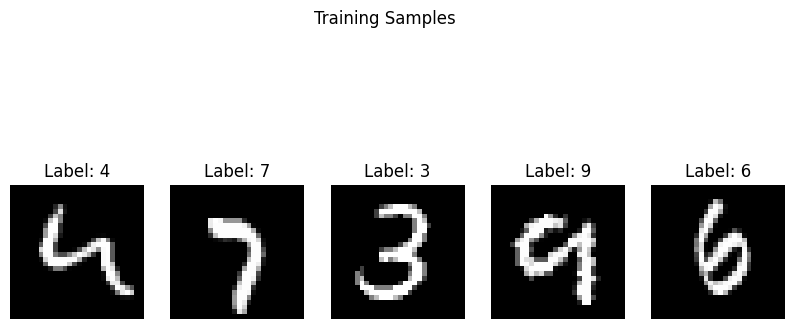

In [21]:
num_samples = 5  # Randomly select indices from the training dataset
train_indices = random.sample(range(len(train_dataset)), num_samples)

train_images1 = torch.stack([train_dataset[i][0] for i in train_indices])
train_labels1 = torch.tensor([train_dataset[i][1] for i in train_indices])

plot_samples(train_images1[:5], train_labels1[:5], class_names, num_samples=5)
plt.suptitle('Training Samples')
plt.show()

## **2. Model Building** 

### **2.1 Model Creation - ResNet**

In [22]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/root/miniconda3/envs/my_pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/my_pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
print(len(train_dataset))

42000


In [24]:
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PIL image if not already in proper format
        if isinstance(image, torch.Tensor):
            image = image.numpy().squeeze(0)  # Convert tensor to numpy array
            image = Image.fromarray((image * 255).astype("uint8"))

        if self.transform:
            image = self.transform(image)

        return image, label


In [25]:
print(type(train_dataset))

<class '__main__.MNISTDataset'>


### Seperacte class for applying the transfromation 

In [26]:
from torch.utils.data import Dataset

class TransformWrapper(Dataset):
    def __init__(self, base_dataset, transform=None):
        """
        A wrapper for applying transformations to an existing dataset.
        :param base_dataset: The original dataset.
        :param transform: A torchvision.transforms object to apply.
        """
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


### Apply the transformations

The data needds to be transformed becacuse the model might get overfitted 

In [27]:
from torchvision import transforms

# Define transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    #transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize
])


In [28]:
# Assume `train_dataset` is your existing dataset
train_dataset_transformed = TransformWrapper(train_dataset, transform=data_transforms)
val_dataset_transformed = TransformWrapper(val_dataset, transform=data_transforms)
test_dataset_transformed = TransformWrapper(test_dataset, transform=data_transforms)


#### Train test and validation datasets are assigned to 3 dataloaders so that they can be fed in to the model in batches 

In [29]:
from torch.utils.data import DataLoader

batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset_transformed, batch_size=batch_size, shuffle=True, num_workers=1),
    'val': DataLoader(val_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=1),
    'test': DataLoader(test_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=1)
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}


In [30]:
print(len(train_dataset))

42000


In [31]:
# Check a sample from the dataset
image, label = train_dataset[100]
print(f"Image type: {type(image)}, Shape: {image.shape}, Label: {label}")


Image type: <class 'torch.Tensor'>, Shape: torch.Size([1, 28, 28]), Label: 5


## Train the model 

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load pretrained ResNet and modify for our task
num_classes = 10
learning_rate = 0.01
num_epochs =10
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(num_ftrs, num_classes)  # Update output layer for your number of classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Train and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize in train phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")



            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)


            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return  model, train_losses, val_losses

# Train and evaluate the model
model, train_losses, val_losses = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

# Save the trained model
torch.save(model.state_dict(), 'resnet_image_recognition1.pth')
print("Model saved as resnet_image_recognition1.pth")


Epoch 0/9
----------
train Loss: 0.1723 Acc: 0.9442
val Loss: 0.1262 Acc: 0.9607

Epoch 1/9
----------
train Loss: 0.0358 Acc: 0.9890
val Loss: 0.1137 Acc: 0.9643

Epoch 2/9
----------
train Loss: 0.0220 Acc: 0.9928
val Loss: 0.0317 Acc: 0.9906

Epoch 3/9
----------
train Loss: 0.0162 Acc: 0.9947
val Loss: 0.0274 Acc: 0.9916

Epoch 4/9
----------
train Loss: 0.0094 Acc: 0.9971
val Loss: 0.0293 Acc: 0.9923

Epoch 5/9
----------
train Loss: 0.0089 Acc: 0.9970
val Loss: 0.0298 Acc: 0.9923

Epoch 6/9
----------
train Loss: 0.0059 Acc: 0.9980
val Loss: 0.0289 Acc: 0.9925

Epoch 7/9
----------
train Loss: 0.0026 Acc: 0.9990
val Loss: 0.0236 Acc: 0.9946

Epoch 8/9
----------
train Loss: 0.0013 Acc: 0.9997
val Loss: 0.0219 Acc: 0.9946

Epoch 9/9
----------
train Loss: 0.0011 Acc: 0.9998
val Loss: 0.0220 Acc: 0.9944

Training complete in 425m 27s
Best val Acc: 0.9946
Model saved as resnet_image_recognition1.pth


### Evaluate the model

In [33]:
def evaluate_model(model, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    
    print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")


### Test the model

In [34]:
evaluate_model(model, criterion)

Test Loss: 0.0151 Acc: 0.9956


### Plot the training and validation losses 

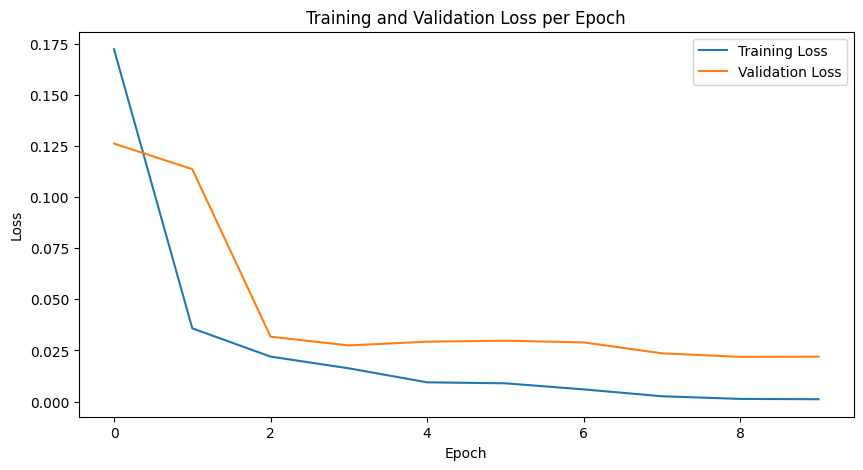

In [35]:
# Train the model


# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()


### Test the model with a custom handwritten image

In [1]:
import torch
import torchvision.models as models

# Define the model
model = models.resnet18(pretrained = False)
num_classes = 10
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)

# Adjust the first layer for single-channel (grayscale) input
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Load the model weights
model.load_state_dict(torch.load('resnet_image_recognition1.pth', map_location=torch.device('cpu')))
model.eval()  # Set to evaluation mode


/root/miniconda3/envs/my_pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/my_pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_938/4133623706.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will b

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
from PIL import Image
import torchvision.transforms as transforms

# Load image, convert to grayscale, and apply the necessary transformations
image = Image.open('one.jpg').convert('L')  # 'L' mode converts to grayscale
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
image = transform(image).unsqueeze(0)  # Add batch dimension

# Now it should work with the model
output = model(image)
print(output)
_, predicted = torch.max(output, 1)
print(f'Predicted class: {predicted.item()}')


tensor([[-0.5439,  9.7053,  0.0467,  2.9239, -6.8092,  3.7081, -1.0019, -1.4344,
         -1.8621, -3.5305]], grad_fn=<AddmmBackward0>)
Predicted class: 1
